# DM-37629 auxTel batoid : separate atmosphere and zk screen

## Setup

* last run 2023/02/01 
* ts_wep v4.0.4
* lsst_distrib w_2023_04

In [1]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 


In [2]:
import importlib as imp
import analysis_tools as at 

## Start atmosphere only once 

Given that I run into trouble with atmosphere simulation, try the following solution from JFC:
    
    # create the simulator at the start of the script/notebook
    # this computes an atmosphere
    simulator = wfsim.SimpleSimulator(...)

    for i in range(100):
        # create a new perturbed telescope for simulations
        perturbed_telescope = ...
        simulator.telescope = perturbed_telescope

        # make sure you reset the image too
        simulator.image.setZero()

        # do the rest of your stuff...

    



In [3]:
import batoid
import galsim

import sys
sys.path.append('/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/wfsim/')
import wfsim

def simulate_defocal_atmosphere(seed = 10, image_shape_x=1000,image_shape_y=1000):
    ''' 
    Simulate auxTel atmosphere only, one intra and one extra-focal simulator.
    
    This is a workaround to allow simulating different zernikes, but 
    with the same telescope setup and atmosphere.
    
    For some reason, trying to re-simulate the atmosphere & zks in a loop
    fails (as of 2/1/2023) -the simulation never finishes. 
    
    
    '''

    auxtel = batoid.Optic.fromYaml("AuxTel.yaml")
    bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')
    rng = np.random.default_rng(seed)

    # parameters associated with the observing conditions
    obs_params = {
        # zenith=0 means straight up, while zenith=90 is the horizon
        # greater zenith angle means more atmospheric turbulence
        "zenith": 30 * galsim.degrees,

        # raw_seeing sets how much atmospheric turbulence there is at zenith=0
        # wfsim uses this to calculate how much turbulence there is at 
        # the zenith angle given above
        "raw_seeing": 0.7 * galsim.arcsec,

        # these next three parameters set attributes of the atmosphere, which
        # help determine how much turbulence there is
        "temperature": 293, # Kelvin
        "pressure": 69, # kPa
        "H2O_pressure": 1, # kPa

        # wavelength of the observed light. this is important because light of 
        # longer/shorter wavelength refracts less/more in the atmosphere
        "wavelength": bandpass.effective_wavelength, # nanometers

        # the AuxTel exposure time
        "exptime": 30, # seconds
    }

    # parameters associated with computational aspects of simulating the atmosphere
    atm_params = {
        "screen_size": 819.2,
        "screen_scale": 0.1,
        "nproc": 3,
        }

    intra = auxtel.withGloballyShiftedOptic(
        "M2", [0, 0, -0.0008]) # meters 
        
    extra = auxtel.withGloballyShiftedOptic(
        "M2", [0, 0, +0.0008])
        
    # Create an intra-focal simulator with just atmosphere:
    intra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        intra,
        bandpass,
        shape=(image_shape_x, image_shape_y),
        rng=rng
    )
        
    # Create an extra-focal simulator with just atmosphere:
    extra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        extra,
        bandpass,
        shape=(image_shape_x, image_shape_y),
        rng=rng
    )
        
    return intra_simulator, extra_simulator 

def simulate_zernike_screen(intra_simulator, extra_simulator, 
                            z_in = np.array([0, 0, 0, 0, 0, 0, 0, 0,0, 0, 300e-9, 0]),
                            thxDeg=0, thyDeg=39/3600,
                            outDir = 'DM-37629',
                            fname = f"auxTel_batoid_test_zk"
                           ):
    # since the wavelength is 622 nm, 
    # +/- 200 nm corresponds to +/- 0.3 waves of perturbation
    #z_in = rng.uniform(-200e-9, 200e-9, size=12)
    ''' 
    Simulate auxTel donuts with input Zernike wavefront as phase screen.
    
    NB: 
    z_in contains z0,z1,z2....z11   
    so eg. z_in = [0,0,0,200e-9,0,0...] means z3=200e-9 [m],
    i.e. 200 nm 
    
    NB: z_in must be in meters! 
    So  eg. result of ts_wep fit, which is in nanometers, 
    needs to be converted to meters ! 
    z_meters = z_nm  * 1e-9 

    thxDeg : x-position of a star in degrees 
    thyDeg : y-position of a star in degrees 
    
    '''

    auxtel = batoid.Optic.fromYaml("AuxTel.yaml")
    phase = batoid.Zernike(
        np.array(z_in),
        R_outer=0.6,
        R_inner=0.2115
    )
    perturbed_telescope = batoid.CompoundOptic(
                (
                batoid.optic.OPDScreen(
                    batoid.Plane(),
                    phase,
                    name='PhaseScreen',
                    obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                    coordSys=auxtel.stopSurface.coordSys
                ),
                *auxtel.items
            ),
            name='PerturbedAuxTel',
            backDist=auxtel.backDist,
            pupilSize=auxtel.pupilSize,
            inMedium=auxtel.inMedium,
            stopSurface=auxtel.stopSurface,
            sphereRadius=auxtel.sphereRadius,
            pupilObscuration=auxtel.pupilObscuration
        )

    # set the image simulator with the perturbed telescope 
    intra_perturbed_telescope = perturbed_telescope.withGloballyShiftedOptic("M2", [0, 0, -0.0008])    
    intra_simulator.telescope = intra_perturbed_telescope
    intra_simulator.image.setZero()

    
    extra_perturbed_telescope = perturbed_telescope.withGloballyShiftedOptic("M2", [0, 0, +0.0008])   
    extra_simulator.telescope = extra_perturbed_telescope
    extra_simulator.image.setZero()
    
    # Now run the image simulation:
    wavelength  =  intra_simulator.bandpass.effective_wavelength * 1e-9 # batoid wants meters 

    # choose a position for the star
    # these angles specify the angle from the optical axis to the star
    thx = np.deg2rad(thxDeg)
    thy = np.deg2rad(thyDeg)

    zk = batoid.zernike(perturbed_telescope, thx, thy, wavelength, eps=0.3525)
    zk *= wavelength  #  waves -> meters 
    
    
    # create a spectrum for the star -- this is needed for chromatic refraction
    # we will randomly select a plausible star temperature, 
    # and calculate the corresponding blackbody spectrum
    rng = intra_simulator.rng
    star_temp = rng.uniform(4_000, 10_000) # Kelvin
    sed = wfsim.BBSED(star_temp) # wfsim has a function to calculate the blackbody spectrum

    # randomly choose a flux (must be an integer)
    flux = 1800000  #rng.integers(1_000_000, 2_000_000)

    intra_simulator.add_star(thx, thy, sed, flux, rng)
    extra_simulator.add_star(thx, thy, sed, flux, rng)
    
    fpath = os.path.join(outDir,fname)
    np.savez(fpath,
             intra=intra_simulator.image.array,
             extra=extra_simulator.image.array,
             zk=zk,
            )
    print(f'saved as {fname}')

    return 

Workflow simulating first atmosphere, then adding different zks... 

In [5]:
# Create a perturbed telescope and set the simulator to it. 
# This can be re-run each time we want different Zks...

intra_simulator, extra_simulator = simulate_defocal_atmosphere(seed = 10, 
                                                               image_shape_x=1000,
                                                               image_shape_y=1000)


In [16]:
for zkNum in range(5,12):
    z_in = np.zeros(12)
    z_in[zkNum] = 300e-9
    simulate_zernike_screen(intra_simulator, extra_simulator, 
                            z_in = z_in,
                            thxDeg=0, thyDeg=39/3600,
                            outDir = 'DM-37629',
                            fname = f"auxTel_batoid_test2_zk{zkNum}"
                           )

saved as auxTel_batoid_test2_zk5
saved as auxTel_batoid_test2_zk6
saved as auxTel_batoid_test2_zk7
saved as auxTel_batoid_test2_zk8
saved as auxTel_batoid_test2_zk9
saved as auxTel_batoid_test2_zk10
saved as auxTel_batoid_test2_zk11


5
6
7
8
9
10
11


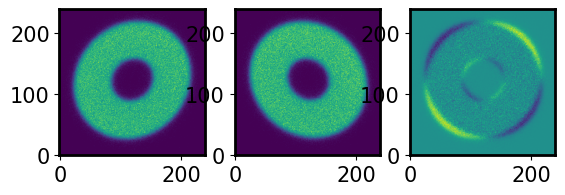

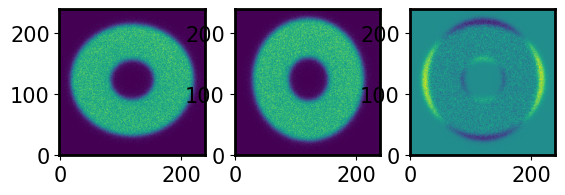

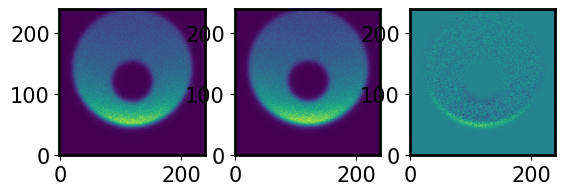

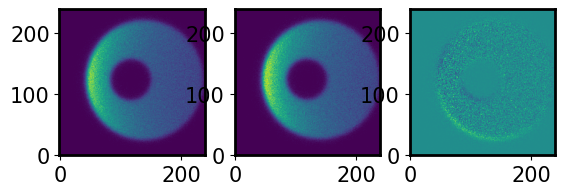

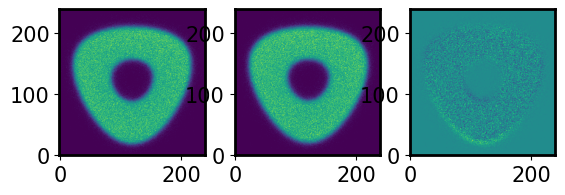

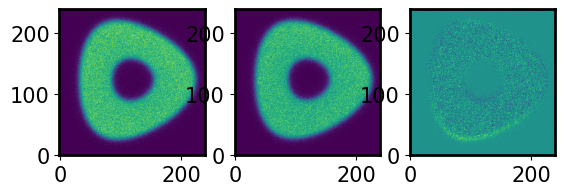

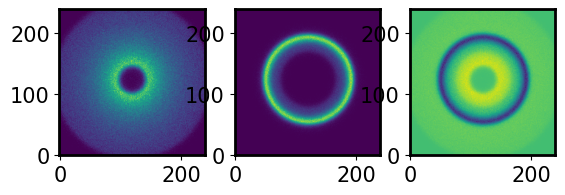

In [4]:
x=500
y=500
side=120
for zkNum in range(5,12):
    outDir = 'DM-37629'
    fname = f"auxTel_batoid_test2_zk{zkNum}.npz"
    print(zkNum)
    fpath = os.path.join(outDir,fname)
    sim = np.load(fpath, allow_pickle=True)
    intra = sim['intra']
    extra = sim['extra']

    fig,ax = plt.subplots(1,3)
    intra_stamp = intra[x-side:x+side,y-side:y+side]
    extra_stamp = extra[x-side:x+side,y-side:y+side]
    
    ax[0].imshow(intra_stamp, origin='lower')
    ax[1].imshow(extra_stamp, origin='lower')
    ax[2].imshow(intra_stamp-extra_stamp, origin='lower')    
    

Fit all these donut pairs with WEP and CWFS:

In [68]:
model = 'onAxis'

res = {'wep':{}, 'cwfs':{}, 'zkintra':{}, 'zkextra':{}, 'intra':{}, 'extra':{}
      }

x=500
y=500
side=120
model = 'onAxis'
for i in range(5,12):    
    fname = f"auxTel_batoid_test2_zk{i}.npz"
    fpath = os.path.join('DM-37629',fname)
    npz = np.load(fpath)
    print(f'fitting {fpath}')
    intra_image = npz['intra']
    extra_image = npz['extra']
    zkintra = npz['zkintra']
    zkextra = npz['zkextra']

    intra_stamp = intra_image[x-side:x+side,y-side:y+side]
    extra_stamp = extra_image[x-side:x+side,y-side:y+side]

    wepZk = at.fit_ts_wep(intra_stamp, extra_stamp, sizeInPix = 240., opticalModel=model)
    res['wep'][i] = wepZk

    cwfsZk = at.fit_cwfs(intra_stamp, extra_stamp, side=120, opticalModel=model)
    res['cwfs'][i] = cwfsZk

    res['zkintra'][i] = zkintra
    res['zkextra'][i] = zkextra

    res['intra'][i]  = intra_stamp
    res['extra'][i]  = extra_stamp

    print('Done')

fitting DM-37629/auxTel_batoid_test2_zk5.npz
Done
fitting DM-37629/auxTel_batoid_test2_zk6.npz
Done
fitting DM-37629/auxTel_batoid_test2_zk7.npz
Done
fitting DM-37629/auxTel_batoid_test2_zk8.npz
Done
fitting DM-37629/auxTel_batoid_test2_zk9.npz
Done
fitting DM-37629/auxTel_batoid_test2_zk10.npz
Done
fitting DM-37629/auxTel_batoid_test2_zk11.npz


Done


Compare the two: plot the intra/extra stamps, and the zkintra, zkextra, wep fit, cwfs fit

In [75]:
def compare(res, zkNum, value=300):
    plt.figure()
    plt.plot(np.arange(4,23), res['wep'][zkNum], '-d', label='ts_wep')
    plt.plot(np.arange(4,23), res['cwfs'][zkNum], '-d', label='cwfs')
    # I plot 5:23 because 
    # I took batoid.zernike(perturbed_telescope) after shifting M2 by 8mm
    # so naturally zkintra was different than zkextra! 
    # zernikes should be stored BEFORE moving M2 ! 
    plt.plot(np.arange(5,23), res['zkintra'][zkNum][5:]*1e9,'-d', label='zk intra batoid ')
    #plt.plot(np.arange(4,23), res['zkextra'][zkNum][4:]*1e9,'-d', label='zk extra batoid ')
    plt.xticks(range(4,22)[::2])
    plt.title(f'zk{zkNum}={value}[nm]')
    plt.legend()
    plt.xlabel('Zk coefficient')
    plt.ylabel('Zk value [nm]')

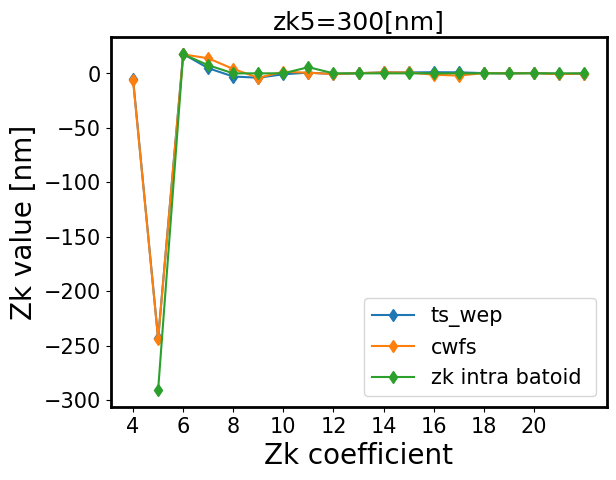

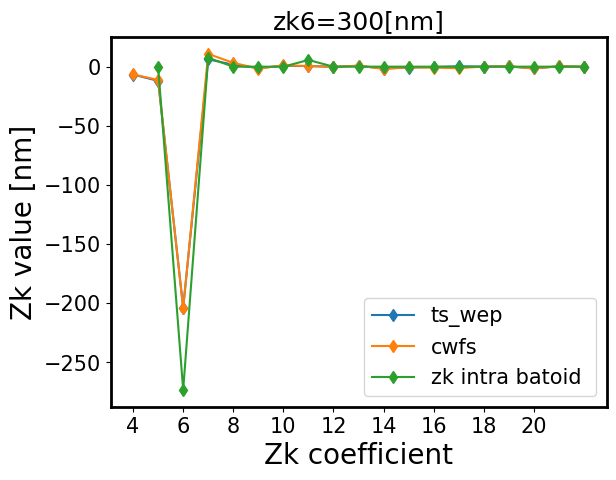

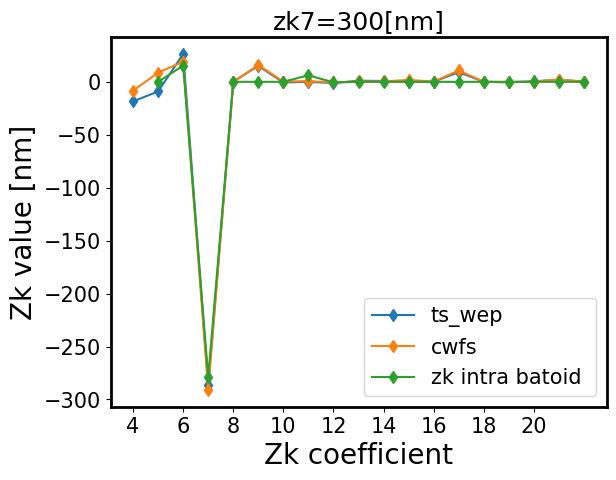

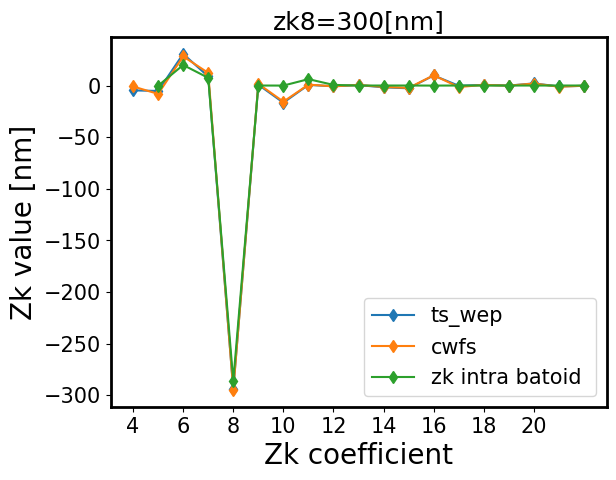

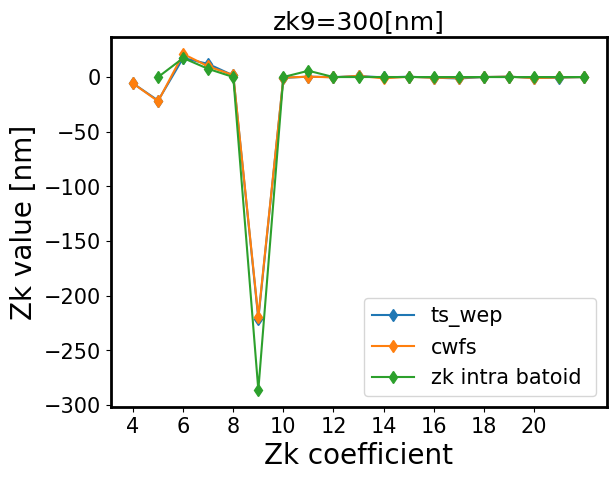

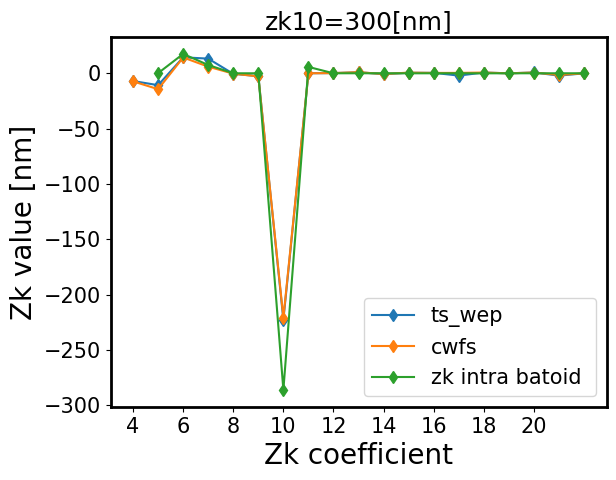

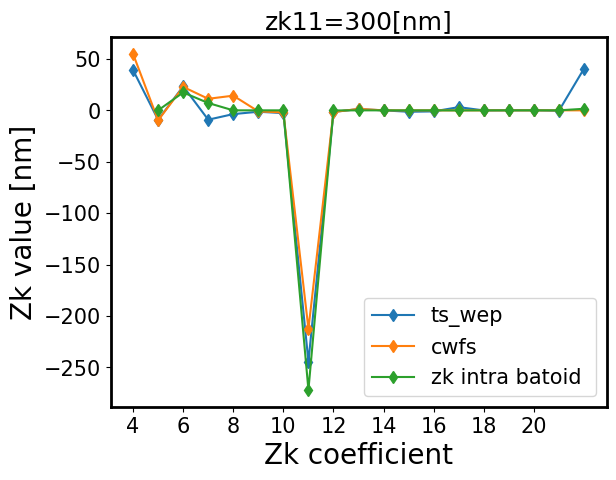

In [76]:
for i in range(5,12):
    compare(res, i)
